In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [ ]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--height 6
--n_objects 50
--n_colours 6
--height 16
--width 16
--seed 2
--n_trajs 10
--n_query 1
--device cpu
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

# env, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
# env.grid

In [ ]:
for i, s in enumerate(env.get_states()):
    if i == 16:
        break

In [ ]:
import torch
import torch.nn as nn
from src.deepmaxent_irl import demo_svf

trajs = generate_demonstrations(env, policy_gt, 
                                n_trajs=args.n_query, 
                                len_traj=args.l_traj, 
                                rand_start=True, 
                                start_pos=None)
device = torch.device(args.device)
N_STATES, _, N_ACTIONS = np.shape(P_a)
mu_D = demo_svf(trajs, N_STATES)
inputs = torch.from_numpy(feat_map).float().to(device)


In [ ]:
np.arange(0, 9).reshape((3, 3), order='F')

In [ ]:
np.sqrt(inputs.size(0)).astype(int)

In [ ]:
input_dim = 2*args.n_colours
height = np.sqrt(inputs.size(0)).astype(int)
inputs_img = inputs.view(height, height, input_dim).permute(2, 1, 0)[None,]
inputs_img[0, :, 0, 1]

In [ ]:
output_dim = 1
hiddens = [8, 8, output_dim]
layers = nn.Sequential(
    nn.Conv2d(input_dim, hiddens[0], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Conv2d(hiddens[0], hiddens[1], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Conv2d(hiddens[1], hiddens[2], kernel_size=3, stride=1, padding=1),
    nn.Tanh()
)

# cnn_layer = nn.Conv2d(input_dim, 8, kernel_size=3, stride=1, padding=0)
o = layers(inputs_img).squeeze()
o.permute(1, 0).reshape(-1).shape

In [ ]:
x = torch.arange(0, 9).reshape((3, 3))
x

## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 32
--width 32
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
--seed 2
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [24]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [27]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 16
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.05
--n_iters 20
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 1.5
--hiddens 8 8
--device cuda
--active
--seed 2
--verbose 2
--architecture dnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[0 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 2 3 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL


  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.9544 -0.9163 -0.9389 -0.8856 -0.5408 -0.1634 -0.2816 -0.6368]
 [-0.7365 -0.3497 -0.6892 -0.214  -0.1634  0.8464  0.8289 -0.0321]
 [-0.352   0.7878 -0.1811  0.8468  0.3723  0.7133 -0.1076  0.6027]
 [-0.3179  0.802  -0.093   0.7165 -0.1634 -0.355   0.3082 -0.5902]
 [-0.3366 -0.2227 -0.5824 -0.5536 -0.7644 -0.8071 -0.2633 -0.4662]
 [ 0.6879 -0.3691 -0.9059 -0.9499 -0.9674 -0.9193 -0.7366 -0.6331]
 [-0.4019 -0.6892 -0.9333 -0.9847 -0.9878 -0.9787 -0.955  -0.9544]
 [-0.9163 -0.9389 -0.9767 -0.9928 -0.9943 -0.9901 -0.9853 -0.9773]]
[INFO - n_trajs:1] Policy evaluation
-- evd = 0.699197 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.523796 ---
[INFO - n_trajs:1] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:1--
[[2.433  2.0812 3.0041 3.2054 3.7372 3.462  3.3791 3.6971]
 [2.7838 2.6896 3.4491 3.5239 3.9581 4.7403 4.4918 4.0154]
 [2.9782 3.9112 3.8999 4.5323 4.6914 4.7096 4.6651 4.2487]
 [3.2051 

  0%|          | 0/20 [00:00<?, ?it/s]

[[ 0.0254 -0.113  -0.5993 -0.6752 -0.5579  0.1373  0.4677  0.5134]
 [ 0.6539  0.6842  0.1829  0.2915  0.1373  0.8102  0.8539  0.7706]
 [ 0.7735  0.8712  0.5217  0.7685  0.1772  0.634   0.5567  0.769 ]
 [ 0.7905  0.8819  0.6182  0.7179  0.1373  0.1221  0.2134 -0.1903]
 [ 0.7949  0.7699  0.5116  0.2209 -0.1473 -0.5963 -0.42   -0.0654]
 [ 0.8673  0.6224 -0.3759 -0.7006 -0.7451 -0.6525 -0.3255 -0.4309]
 [ 0.6645  0.1829 -0.7104 -0.9352 -0.9265 -0.756  -0.7078 -0.7456]
 [-0.113  -0.5993 -0.9052 -0.9823 -0.9655 -0.8679 -0.8757 -0.8854]]
[INFO - n_trajs:2] Policy evaluation
-- evd = 1.298796 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.641676 ---
[INFO - n_trajs:2] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:2--
[[3.3015 3.3441 3.501  3.1193 4.2151 5.0052 5.6124 5.4485]
 [4.7112 4.6828 4.453  4.0267 4.1908 5.0097 5.7879 5.6192]
 [5.9773 5.9475 5.0411 4.8194 4.6139 5.0987 5.176  4.9015]
 [6.3627 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.9992 -0.9969 -0.9947 -0.9745 -0.6049 -0.6961 -0.9193 -0.9813]
 [-0.9957 -0.9749 -0.9772 -0.8263 -0.6961  0.6671  0.2188 -0.9081]
 [-0.9863 -0.4833 -0.8745  0.7483  0.6738  0.2011 -0.8271 -0.657 ]
 [-0.9856 -0.438  -0.8483  0.0285 -0.6961 -0.8875 -0.7658 -0.9591]
 [-0.9877 -0.9697 -0.9699 -0.9726 -0.9823 -0.9743 -0.4569 -0.7803]
 [-0.8702 -0.9706 -0.9934 -0.9973 -0.9985 -0.9862 -0.8601 -0.1278]
 [-0.9799 -0.9772 -0.9903 -0.9974 -0.9984 -0.9975 -0.9857 -0.9745]
 [-0.9969 -0.9947 -0.9954 -0.9972 -0.9982 -0.9974 -0.9907 -0.9375]]
[INFO - n_trajs:3] Policy evaluation
-- evd = 0.564462 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.347256 ---
[INFO - n_trajs:3] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:3--
[[4.7855 4.2226 3.7224 3.4436 3.4885 2.6579 2.5435 3.0359]
 [3.8238 3.3183 2.9711 2.7486 3.6086 3.569  2.7502 2.2614]
 [2.2108 2.1312 2.2009 3.178  3.7885 3.8342 3.3051 3.2674]
 [2.5155 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.9693 -0.9218 -0.8722 -0.5807  0.5319  0.262  -0.3813 -0.4661]
 [-0.8802 -0.6541 -0.7002 -0.0272  0.262   0.8684  0.8066  0.6753]
 [-0.6884  0.4684  0.1266  0.8465  0.611   0.9129  0.4872  0.9144]
 [-0.606   0.6471  0.5319  0.9258  0.262   0.0949  0.7177 -0.2787]
 [-0.6611 -0.2106 -0.0471 -0.0733 -0.5433 -0.5679  0.6239  0.1333]
 [-0.4939 -0.6925 -0.8585 -0.9153 -0.9435 -0.7388 -0.0506 -0.1117]
 [-0.7673 -0.7002 -0.7889 -0.9013 -0.9338 -0.9252 -0.8441 -0.8635]
 [-0.9218 -0.8722 -0.8588 -0.874  -0.9258 -0.9231 -0.9558 -0.9418]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 0.288241 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.418847 ---
[INFO - n_trajs:4] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:4--
[[3.4363 3.1026 3.0828 3.6428 4.9015 4.5854 4.4123 3.8298]
 [2.8958 2.645  3.5654 4.2915 4.9887 5.8558 6.0476 5.3942]
 [2.1989 3.1103 3.456  4.6627 5.1059 5.9295 6.0763 5.1122]
 [1.8532 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.9267 -0.8787 -0.8677 -0.7656 -0.353  -0.3056 -0.5226 -0.6651]
 [-0.8142 -0.637  -0.7196 -0.4054 -0.3056  0.5679  0.47   -0.1961]
 [-0.6617  0.226  -0.3791  0.5627  0.3183  0.3044 -0.2574  0.0904]
 [-0.6323  0.3128 -0.2454  0.3181 -0.3056 -0.4801 -0.3184 -0.6682]
 [-0.6538 -0.5083 -0.5719 -0.6424 -0.7436 -0.7645 -0.2652 -0.3886]
 [-0.2326 -0.6478 -0.8457 -0.9043 -0.9247 -0.811  -0.4913 -0.1847]
 [-0.6875 -0.7196 -0.8402 -0.9208 -0.9327 -0.9051 -0.8226 -0.8017]
 [-0.8787 -0.8677 -0.8971 -0.9316 -0.9351 -0.9089 -0.89   -0.8103]]
[INFO - n_trajs:5] Policy evaluation
-- evd = 0.427229 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.437203 ---
[INFO - n_trajs:5] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:5--
[[4.1046 3.6072 4.1792 4.3134 4.5462 3.945  3.8028 4.0789]
 [3.8242 3.4863 3.9258 4.0753 4.6916 5.0815 4.6649 4.1915]
 [3.4476 4.3597 3.7086 4.6883 5.2615 5.1133 4.8979 4.9233]
 [3.5177 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.8386 -0.735  -0.6973 -0.4977  0.025   0.026  -0.2171 -0.3797]
 [-0.6371 -0.3698 -0.4649 -0.0791  0.026   0.6186  0.5652  0.1721]
 [-0.406   0.3946 -0.0425  0.6026  0.5201  0.4006  0.0909  0.247 ]
 [-0.3615  0.4681  0.1071  0.4235  0.026  -0.1776 -0.155  -0.4391]
 [-0.3938 -0.1881 -0.2383 -0.4068 -0.5185 -0.5509  0.0496  0.0016]
 [ 0.0095 -0.386  -0.662  -0.7933 -0.8325 -0.5689 -0.0317  0.3444]
 [-0.4449 -0.4649 -0.6343 -0.7935 -0.8219 -0.7422 -0.5145 -0.4316]
 [-0.735  -0.6973 -0.7368 -0.7996 -0.7921 -0.6974 -0.6082 -0.3067]]
[INFO - n_trajs:6] Policy evaluation
-- evd = 0.356316 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.315414 ---
[INFO - n_trajs:6] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:6--
[[3.9182 3.6172 4.4051 4.8221 5.3501 4.9976 4.8513 4.821 ]
 [3.8665 3.7072 4.3731 4.8529 5.5817 5.9925 5.6869 5.2314]
 [3.6968 4.6604 4.3554 5.2449 5.9068 5.917  5.7343 5.6119]
 [3.8157 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.7517 -0.6456 -0.6512 -0.5065 -0.1043  0.0633 -0.0785 -0.1352]
 [-0.431  -0.1328 -0.3563  0.0068  0.0633  0.7065  0.7158  0.5022]
 [-0.0807  0.6393  0.1419  0.662   0.471   0.462   0.2913  0.4641]
 [ 0.0062  0.7021  0.3395  0.5329  0.0633 -0.1086 -0.17   -0.4203]
 [-0.03    0.1851  0.0372 -0.276  -0.4421 -0.575  -0.0837  0.0404]
 [ 0.3414 -0.2015 -0.5962 -0.7689 -0.8031 -0.5429  0.0096  0.2673]
 [-0.2499 -0.3563 -0.6162 -0.7893 -0.8036 -0.6749 -0.4687 -0.4218]
 [-0.6456 -0.6512 -0.7354 -0.8172 -0.7728 -0.611  -0.6009 -0.4098]]
[INFO - n_trajs:7] Policy evaluation
-- evd = 0.443904 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.270016 ---
[INFO - n_trajs:7] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:7--
[[3.0413 2.8467 4.064  4.5972 4.8787 4.6966 4.7064 4.6114]
 [3.654  3.6033 4.605  4.9261 5.1059 5.6353 5.8361 5.4244]
 [4.3348 5.1091 5.6644 5.9121 5.9357 5.6788 5.5078 5.263 ]
 [4.5775 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.8488 -0.7781 -0.8088 -0.7044 -0.2434 -0.0482 -0.2279 -0.3808]
 [-0.6216 -0.3435 -0.5211 -0.1225 -0.0482  0.7323  0.6853  0.2844]
 [-0.3623  0.501  -0.0303  0.7104  0.6636  0.3066  0.1222  0.1176]
 [-0.3066  0.5835  0.1587  0.3707 -0.0482 -0.3412 -0.5583 -0.6786]
 [-0.3428 -0.1139 -0.2377 -0.6027 -0.6836 -0.7835 -0.254  -0.0375]
 [ 0.0411 -0.3748 -0.7559 -0.9034 -0.9211 -0.723  -0.0211  0.5843]
 [-0.4304 -0.5211 -0.793  -0.9263 -0.9288 -0.811  -0.5471 -0.3881]
 [-0.7781 -0.8088 -0.8917 -0.9504 -0.909  -0.7346 -0.5447  0.0296]]
[INFO - n_trajs:8] Policy evaluation
-- evd = 0.341696 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.317167 ---
[INFO - n_trajs:8] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:8--
[[3.3006 2.8417 3.7097 4.0825 4.5056 4.1166 4.0252 4.0978]
 [3.5578 3.3438 3.8855 4.1068 4.8043 5.1387 4.956  4.4594]
 [3.6421 4.6121 4.1218 4.6843 5.1815 5.0424 4.6247 4.6312]
 [3.8114 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.9236 -0.8709 -0.8741 -0.784  -0.4161 -0.2563 -0.4283 -0.5954]
 [-0.7723 -0.536  -0.6768 -0.3292 -0.2563  0.6213  0.5782 -0.0126]
 [-0.559   0.4056 -0.2683  0.5952  0.2623  0.3632 -0.1389  0.2532]
 [-0.5186  0.4852 -0.1122  0.4098 -0.2563 -0.4315 -0.2777 -0.6562]
 [-0.5468 -0.3638 -0.4885 -0.6026 -0.7302 -0.7788 -0.3189 -0.3601]
 [-0.0197 -0.5555 -0.8429 -0.9144 -0.9344 -0.8226 -0.4871 -0.2392]
 [-0.6011 -0.6768 -0.8543 -0.9405 -0.9485 -0.9146 -0.8309 -0.8104]
 [-0.8709 -0.8741 -0.9189 -0.9557 -0.9536 -0.9224 -0.8988 -0.8265]]
[INFO - n_trajs:9] Policy evaluation
-- evd = 0.438913 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.808961 ---
[INFO - n_trajs:9] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:9--
[[3.5506 3.0121 3.9006 4.0994 4.3009 3.8651 3.7927 4.0205]
 [3.5702 3.3097 3.935  4.0835 4.4287 5.0101 4.8493 4.4688]
 [3.478  4.4924 4.1131 4.877  5.1896 4.9646 4.8663 4.8683]
 [3.6037 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.2872 -0.1512 -0.297  -0.1632  0.2654  0.5211  0.4799  0.5218]
 [ 0.2962  0.5119  0.223   0.5072  0.5211  0.8922  0.9054  0.8651]
 [ 0.5985  0.8823  0.6454  0.865   0.8543  0.6025  0.7337  0.6084]
 [ 0.6632  0.9091  0.7684  0.6903  0.5211  0.2817 -0.3148 -0.2637]
 [ 0.6449  0.7439  0.6402  0.0026 -0.1109 -0.4666  0.1543  0.6031]
 [ 0.7532  0.429  -0.152  -0.6679 -0.7037 -0.1027  0.6981  0.8918]
 [ 0.4054  0.223  -0.3055 -0.7113 -0.6908 -0.0789  0.4346  0.6034]
 [-0.1512 -0.297  -0.5908 -0.8003 -0.4833  0.3782  0.5574  0.8488]]
[INFO - n_trajs:10] Policy evaluation
-- evd = 0.893033 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.280825 ---


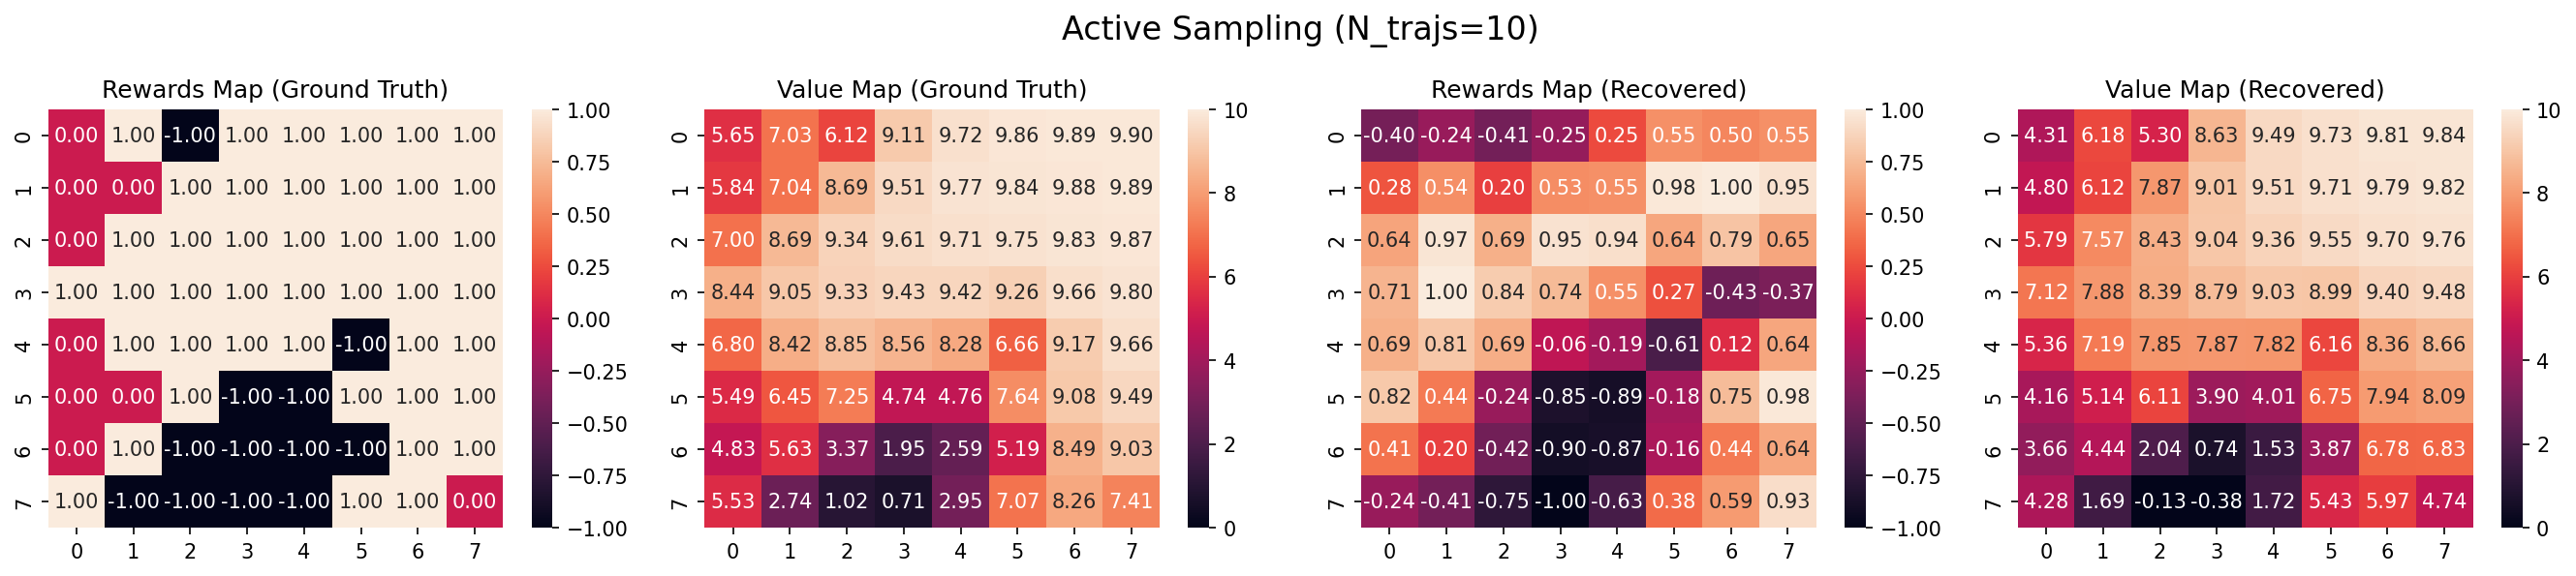

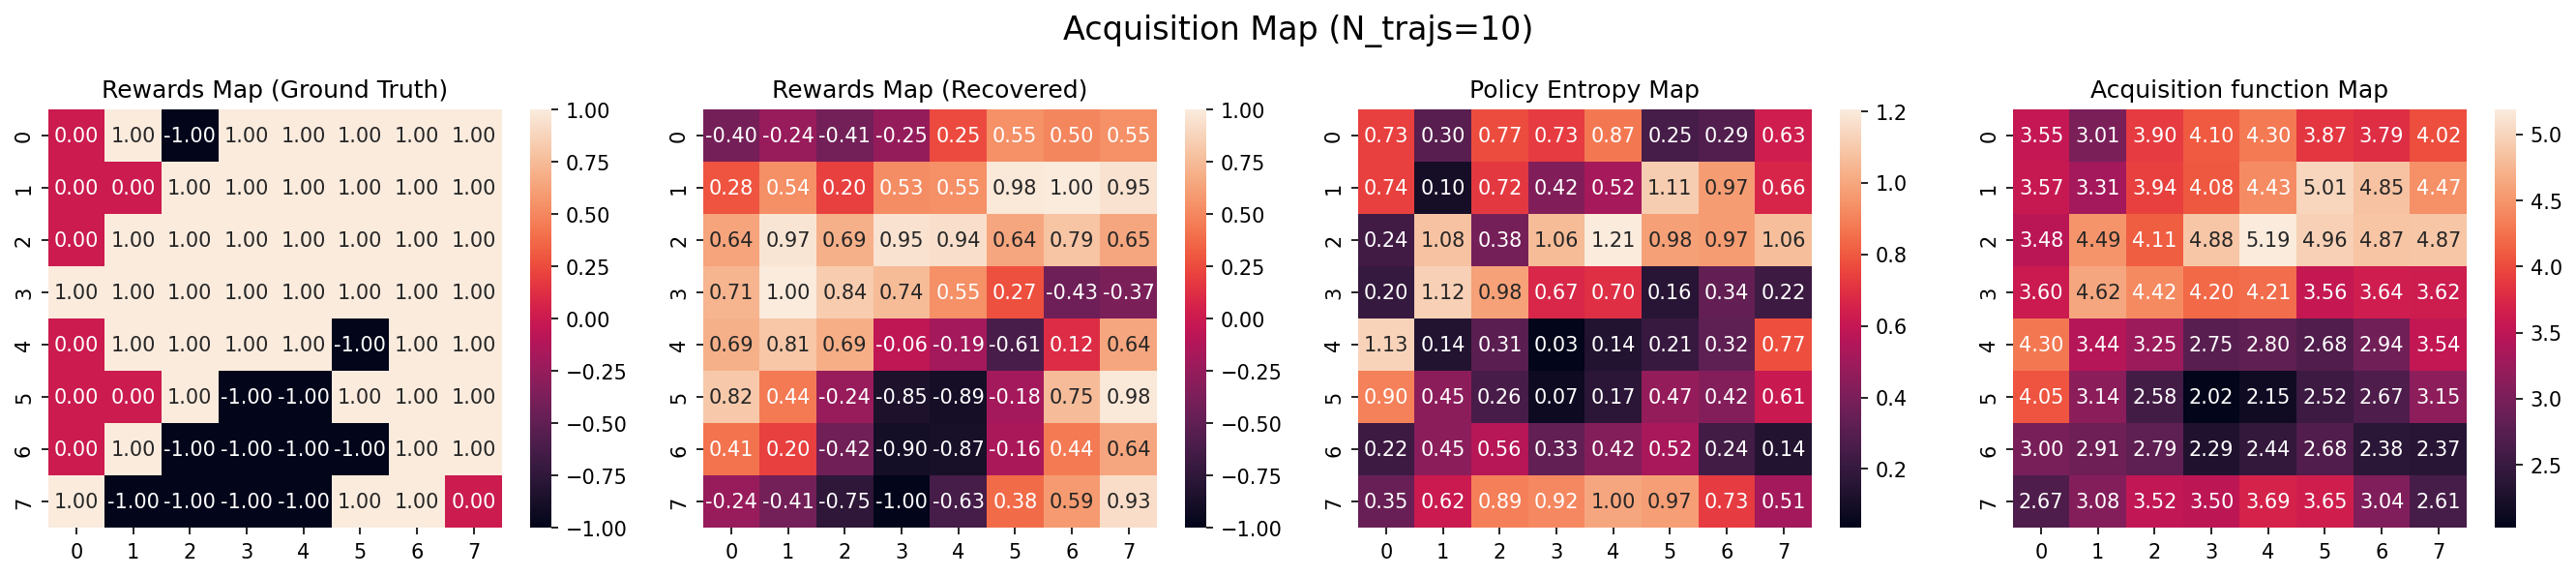

In [28]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)

In [ ]:
visualizer.objectworld_reward_policy(search_idx=n_trajs)